### Business Problem

Develop a machine learning framework to categorize and group customer support tweets to discern prevalent customer issues, gauge their urgency and sentiment, and enhance response prioritization. This initiative will not only streamline the allocation of support resources but also furnish product development with actionable insights, thereby boosting customer satisfaction and fostering proactive engagement. Ultimately, this will refine the company's customer service operations and guide improvements in product and service offerings.

### Data Extraction

##### Load the data

In [1]:
import os
os.chdir('/Users/eshithahemakumar/Documents/Eshitha/ML/NLP/Data')
print(os.getcwd())

/Users/eshithahemakumar/Documents/Eshitha/ML/NLP/Data


In [3]:
import pandas as pd

file_dir = os.getcwd()
file_path = os.path.join(file_dir, 'twcs.csv')
twitter_support_data = pd.read_csv(file_path)

### Exploratory Data Analysis

In [4]:
# Look at the data
print(twitter_support_data)

# Descriptive Statistics
print(twitter_support_data.describe())
print(twitter_support_data.info())

# Missing values
print(twitter_support_data.isna().sum())

# Duplicate values
print(twitter_support_data.duplicated().any())

         tweet_id   author_id  inbound                      created_at  \
0               1  sprintcare    False  Tue Oct 31 22:10:47 +0000 2017   
1               2      115712     True  Tue Oct 31 22:11:45 +0000 2017   
2               3      115712     True  Tue Oct 31 22:08:27 +0000 2017   
3               4  sprintcare    False  Tue Oct 31 21:54:49 +0000 2017   
4               5      115712     True  Tue Oct 31 21:49:35 +0000 2017   
...           ...         ...      ...                             ...   
2811769   2987947  sprintcare    False  Wed Nov 22 08:43:51 +0000 2017   
2811770   2987948      823869     True  Wed Nov 22 08:35:16 +0000 2017   
2811771   2812240      121673     True  Thu Nov 23 04:13:07 +0000 2017   
2811772   2987949      AldiUK    False  Wed Nov 22 08:31:24 +0000 2017   
2811773   2987950      823870     True  Tue Nov 21 22:01:04 +0000 2017   

                                                      text response_tweet_id  \
0        @115712 I understand. 

### Data Preprocessing

##### Clean Text

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Filter down to initial tweets to identify primary issue
initial_tweets_df = twitter_support_data[twitter_support_data['in_response_to_tweet_id'].isnull()].copy()

# Function to clean the text by removing noise such as URLs, mentions, special characters, and numbers
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # Remove hashtags 
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Normalize to lowercase
    return text

# Function to tokenize the tweets into words, remove stop words, and apply lemmatization
def preprocess_text(text):
    stop_words_set = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    text = clean_text(text)  # Clean the text
    tokens = word_tokenize(text)  # Tokenize into words
    
    # Remove stop words and lemmatize
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words_set]
    return ' '.join(processed_tokens)

initial_tweets_df.loc[:, 'clean_text'] = initial_tweets_df['text'].apply(preprocess_text)
print(initial_tweets_df.head())


    tweet_id author_id  inbound                      created_at  \
6          8    115712     True  Tue Oct 31 21:45:10 +0000 2017   
12        18    115713     True  Tue Oct 31 19:56:01 +0000 2017   
14        20    115715     True  Tue Oct 31 22:03:34 +0000 2017   
23        29    115716     True  Tue Oct 31 22:01:35 +0000 2017   
25        31    115717     True  Tue Oct 31 22:06:54 +0000 2017   

                                                 text response_tweet_id  \
6           @sprintcare is the worst customer service            9,6,10   
12  @115714 y’all lie about your “great” connectio...                17   
14  @115714 whenever I contact customer support, t...                19   
23  actually that's a broken link you sent me and ...                28   
25  Yo @Ask_Spectrum, your customer service reps a...                30   

    in_response_to_tweet_id                                         clean_text  
6                       NaN                             worst cus

##### Extract mentions for company name

In [6]:
# Function to extract mentions and map them to companies
def extract_mentions(text):
    mentions = re.findall(r'@\w+', text)
    return mentions

initial_tweets_df.loc[:, 'mentions'] = initial_tweets_df['text'].apply(extract_mentions)
initial_tweets_df['mentions_string'] = initial_tweets_df['mentions'].apply(lambda x: ' '.join(map(str, x)))
print(initial_tweets_df['mentions_string'].value_counts())                                                                  

# sampling
# initial_tweets_df = initial_tweets_df.sample(frac=0.001, random_state=1)

mentions_string
                                       56367
@AppleSupport                          40544
@115858                                24349
@AmericanAir                           21133
@Delta                                 19027
                                       ...  
@123765 @TwitterSupport @47210             1
@115955 @Ask_Spectrum @1625                1
@Delta @47205 @47206 @47207 @377453        1
@1540                                      1
@116021 @116072 @115725                    1
Name: count, Length: 52770, dtype: int64


##### Replace mentions 

In [7]:
# Replace numerical mentions by reviewing text
# 1.
mentions_df_1 = initial_tweets_df[initial_tweets_df['mentions_string'] == '@115858']
# print(mentions_df_1['text'])

'''
417                     Tf is wrong with my keyboard @115858
454        Hey @115858! Last time I downloaded an update ...
462        I just need @115858 to do something about the ...
1165       Why does my I️ not work ?! \n@115858 please fi...
1171           iOS 11 is killing my battery @115858. Fix it.
                                 ...                        
2810581    @115858 just to let you know I received these ...
2810887    im so upset over this @115858 update, every ti...
2810999    So help me god I will never buy another @11585...
2811098    @115858 why is it whenever a new iphone gets l...
2811114    Before installing iOS 11 on my @115858 iPhone,...
'''

#2.
mentions_df_2 = initial_tweets_df[initial_tweets_df['mentions_string'] == '@115873']
# print(mentions_df_2['text'])

'''
466        @115873 you need to correct false charges from...
468        @115873 my driver just drove me to the departm...
479        1 hour+ inside an old Altima that smells and h...
1205       @115873 wtf is this.. every time I try to use ...
1210       @115873 hi just for a ride and it seemed to th...
                                 ...                        
2811169    Yo @115873 Im not tryin to get double charged ...
2811173    How is it @115873 don’t have an option for onl...
2811178    @115873 ,It’s absolute nonsense that it took 2...
2811473    @115873 one of yo9ur drivers has my iphone in ...
2811475    @115873 why do I have to have a credit when yo...
'''

#3.
mentions_df_3 = initial_tweets_df[initial_tweets_df['mentions_string'] == '@115821']
# print(mentions_df_3['text'])

'''
325        Way to drop the ball on customer service @1158...
365        @115821, it’d be nice if the book I waited 4 m...
368        CONCURSO 👻🎃:Tarjetas regalo en @115821 por tu ...
373        Anna Inspired in idea lab at school to be @115...
382        My package from @115821 with my Halloween cost...
                                 ...                        
2810994    Dear @115821,\n\nSee anything wrong with this ...
2810996    Holy crap @115821, you need to get better CSRs...
2811073    Why have you lied to me @115821.... First you ...
2811094    Hey @115821, If a customer emails with two que...
2811372    This is happening in my area w/@115821 “Prime”...
'''

#4. 
mentions_df_4 = initial_tweets_df[initial_tweets_df['mentions_string'] == '@115850']
# print(mentions_df_4['text'])

'''
3854        @115850 का एकाउंट परमानेंटली डिलीट कैसे करते है?
4308       @115850 I have stopped ordering from your site...
5734       @115850 pls investigate ur satara (Maharashtra...
6170       @115850 order ID ending with 5148337, I paid u...
6672       @115850 Why can't the updates move properly ht...
                                 ...                        
2810298    Hi @115850! I want to change the address on a ...
2811070    @115850 OD-171-2957972-5490713 This item is no...
2811076    @115850 \nWhat about the ONEPLUS 5T quiz results?
2811096    @115850 sare giveaway ke winners  kaha announc...
2811639    @115850  there should be bonus and gifts for r...
Name: text, Length: 9882, dtype: object
'''

#5. 
mentions_df_5 = initial_tweets_df[initial_tweets_df['mentions_string'] == '@115888']
# print(mentions_df_5['text'])

'''
547        i’m pissed my @115888 shuffle and repeat butto...
1279       Why are my devices not doing the cool thing wh...
2057       😩 @115888 you take up too much storage even wi...
2100       @115888 the app is killing #phone #battery  fi...
2102       @115888 this layout looks nice, but really isn...
                                 ...                        
2810110    @115888 I created an account today. I cashed t...
2810228                   release radar is going OFF @115888
2810351    I want to know how to use spotify with the pre...
2810376    @115888 how does the $0.99 Cdn/mth promo work ...
2810404                       @115888 hey I have a question.
Name: text, Length: 9720, dtype: object
'''

#6. 
mentions_df_6 = initial_tweets_df[initial_tweets_df['mentions_string'] == '@115911']
# print(mentions_df_6['text'])

'''
1343       @115911    Who’s looking in your window at nig...
1350       Finally free of the @115911 chains here I come...
1375                 @115911 once again you are being slow 😑
1378       #Thankenstein + #Contest @115911 Keeping it cr...
2254       Hey @115911 how come none of the #TMobileTuesd...
                                 ...                        
2811566    @115911 is there any hope for better service i...
2811568    I really hate @115911 right now 😡😡😡😡 paid off ...
2811606    Man bro y’all so fucking trash and im irritate...
2811614               Back again with another issue. @115911
2811616    @115911 it's been two weeks. fix this. https:/...
Name: text, Length: 7875, dtype: object
'''


#7. 
mentions_df_7 = initial_tweets_df[initial_tweets_df['mentions_string'] == '@116062']
# print(mentions_df_7['text'])

'''
1056       @116062 has disgustingly mismanaged the releas...
1058       How can I give this out?  Wtf @116062 https://...
2472       Come on @116062!  Where’s the diversity??  #wh...
2531       @116062 I’m trying to find DPCI 030-02-8711. N...
3426       @116062 You have a new team member starting to...
                                 ...                        
2808718    @116062 I expect royalties for using my doggy’...
2809619    Went to Target looking for a mug and couldn't ...
2810565    Thanks a lot @116062... even after 4 washes yo...
2811342    @116062 returns dpt./ security dpt. at #buckea...
2811579    @116062 what’s up with this month’s ad? It’s r...
Name: text, Length: 7517, dtype: object
'''

#8. 
mentions_df_8 = initial_tweets_df[initial_tweets_df['mentions_string'] == '@115714']
print(mentions_df_8['text'].head(10))

'''
12         @115714 y’all lie about your “great” connectio...
14         @115714 whenever I contact customer support, t...
748                       @115714 fuck you fix my connection
762        @115714 you wanna actually turn on your intern...
1420       @115714 customer service 👎! 4 different people...
                                 ...                        
2811184    I missed out on so much over time because of @...
2811186    @115714 why has my LTE service been down since...
2811283    Get AppleCare, not the crappy add-on “insuranc...
2811489    Thanks @115714 love my #note8 still miss my #n...
2811770    @115714 wtf!? I’ve been having really shitty s...
Name: text, Length: 7097, dtype: object
'''

full_text = twitter_support_data.loc[2811770, 'text']
print(full_text)

12      @115714 y’all lie about your “great” connectio...
14      @115714 whenever I contact customer support, t...
748                    @115714 fuck you fix my connection
762     @115714 you wanna actually turn on your intern...
1420    @115714 customer service 👎! 4 different people...
1423    @115714 chk ur latest bill. I paid for note 8 ...
1427                            @115714 is honestly trash
3153    Ugh @115714 stop being such a tease https://t....
4595    anyone and everyone....if you decide to do bus...
5041    @115714 had THEE worst service on the planet fam.
Name: text, dtype: object
@115714 wtf!? I’ve been having really shitty service all day !! Get your shit together!


In [8]:
# Replace values
initial_tweets_df['mentions_string'] = initial_tweets_df['mentions_string'].str.replace('@115858', '@AppleSupport', regex=False)
initial_tweets_df['mentions_string'] = initial_tweets_df['mentions_string'].str.replace('@115873', '@Uber_Support', regex=False)
initial_tweets_df['mentions_string'] = initial_tweets_df['mentions_string'].str.replace('@115821', '@AmazonHelp', regex=False)
initial_tweets_df['mentions_string'] = initial_tweets_df['mentions_string'].str.replace('@115850', '@AmazonHelp', regex=False)
initial_tweets_df['mentions_string'] = initial_tweets_df['mentions_string'].str.replace('@115888', '@SpotifyCares', regex=False)
initial_tweets_df['mentions_string'] = initial_tweets_df['mentions_string'].str.replace('@115911', '@TMobile', regex=False)
initial_tweets_df['mentions_string'] = initial_tweets_df['mentions_string'].str.replace('@116062', '@Target', regex=False)
initial_tweets_df['mentions_string'] = initial_tweets_df['mentions_string'].str.replace('@115714', '@Sprint', regex=False)

tweet_volumes_per_mention = initial_tweets_df['mentions_string'].value_counts()
tweet_volumes_per_mention_df = tweet_volumes_per_mention.reset_index()
tweet_volumes_per_mention_df.columns = ['mentions_string', 'tweet_count']

### Data Visualization

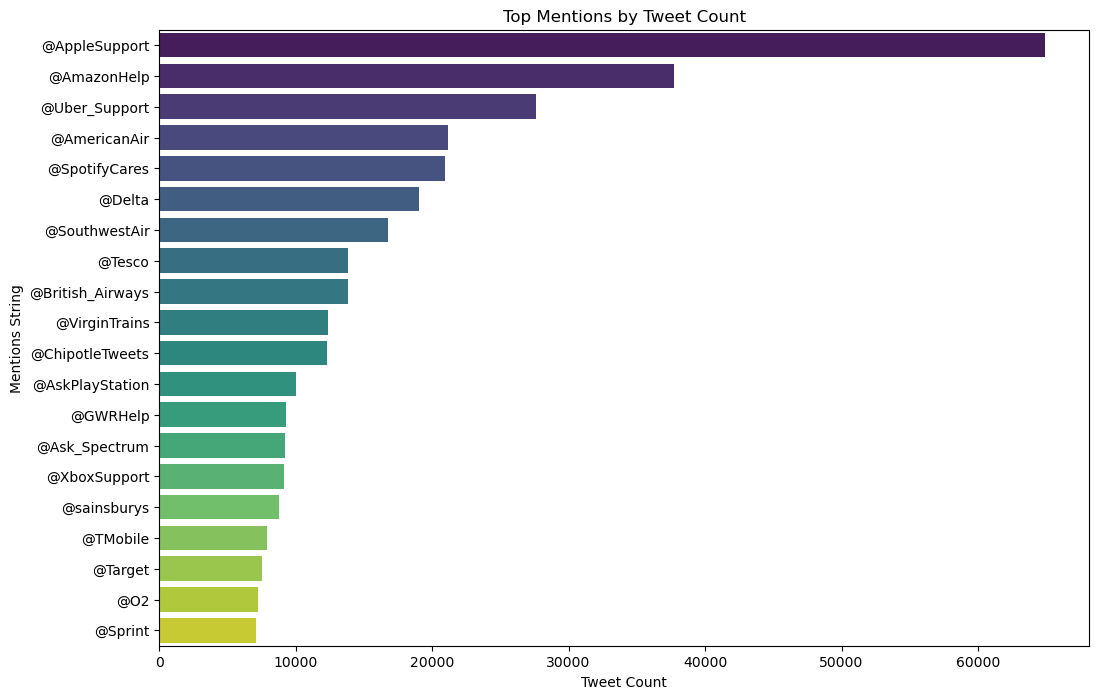

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Select top N mentions_strings
top_n = 20
# filter rows where mentions is empty
filtered_mentions = tweet_volumes_per_mention_df[tweet_volumes_per_mention_df['mentions_string'].str.strip() != '']
top_mentions = filtered_mentions.sort_values('tweet_count', ascending=False).head(top_n)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='tweet_count', y='mentions_string', data=top_mentions, palette='viridis')
plt.title('Top Mentions by Tweet Count')
plt.xlabel('Tweet Count')
plt.ylabel('Mentions String')
plt.show()

### Sentiment Analysis

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer

# sampling
initial_tweets_df = initial_tweets_df.sample(frac=0.001, random_state=1)

# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores and add them as a new column to the DataFrame
initial_tweets_df['sentiment_score'] = initial_tweets_df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Group by 'mentions_string' and calculate the mean sentiment score for each
mention_sentiment = initial_tweets_df.groupby('mentions_string')['sentiment_score'].mean().reset_index()

# Sort the mentions by average sentiment score
mention_sentiment_sorted = mention_sentiment.sort_values('sentiment_score')

# Separate the mentions into positive and negative sentiment
positive_sentiment = mention_sentiment_sorted[mention_sentiment_sorted['sentiment_score'] > 0]
negative_sentiment = mention_sentiment_sorted[mention_sentiment_sorted['sentiment_score'] < 0]

# Take the top 25 mentions from each group
top_positive = positive_sentiment.tail(25)  # since tail will give the largest
top_negative = negative_sentiment.head(25)  # since head will give the smallest

print(len(top_positive))  # Should be 25 if enough data is present
print(len(top_negative))  # Should be 25 if enough data is present

# Combine the two top 25 lists
top_mentions = pd.concat([top_positive, top_negative])

25
25


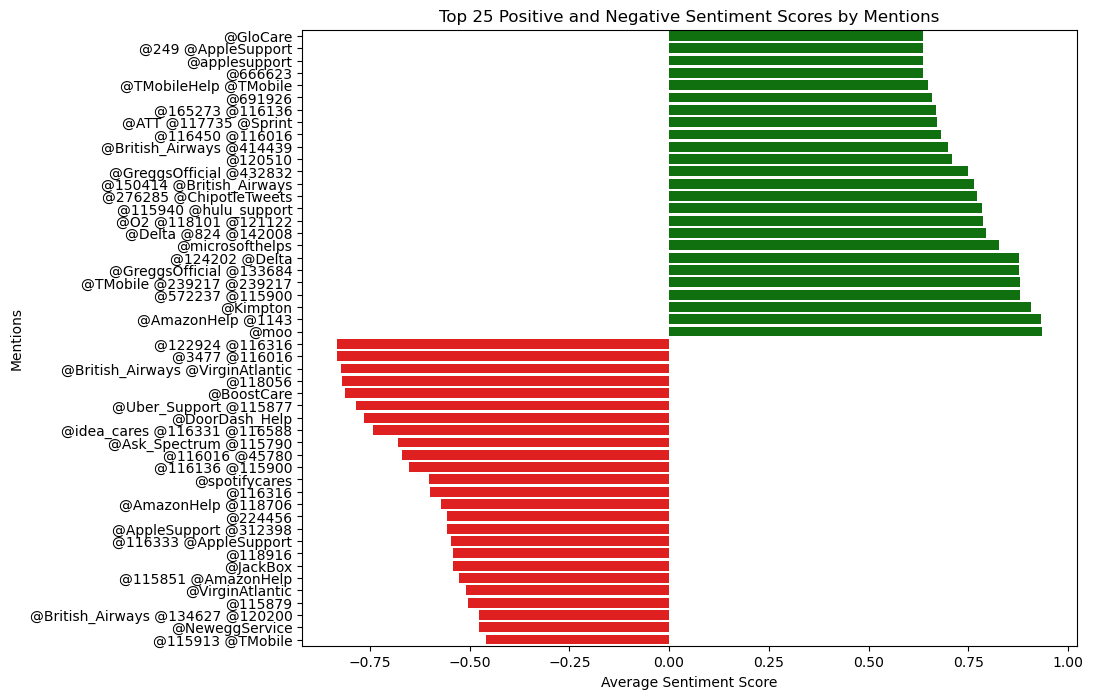

In [11]:
# Visualize
plt.figure(figsize=(10, 8))  # Adjust size to fit the 50 mentions
sns.barplot(x='sentiment_score', y='mentions_string', data=top_mentions,
            palette=top_mentions['sentiment_score'].apply(lambda x: 'green' if x > 0 else 'red'))
plt.xlabel('Average Sentiment Score')
plt.ylabel('Mentions')
plt.title('Top 25 Positive and Negative Sentiment Scores by Mentions')
plt.show()

In [12]:
initial_tweets_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,clean_text,mentions,mentions_string,sentiment_score
1856667,2013221,595289,True,Wed Oct 18 19:53:13 +0000 2017,@Uber_Support Had some worst and unprofessiona...,2013220,NaN,worst unprofessional service uber today please...,[@Uber_Support],@Uber_Support,-0.5267
1926001,2080202,615208,True,Mon Oct 09 17:02:18 +0000 2017,@115955 is the Worst Cable Provider. MTV comes...,2080201,NaN,worst cable provider mtv come basic cable pay ...,[@115955],@115955,-0.5520
2100352,2260603,658233,True,Sat Nov 11 02:16:49 +0000 2017,Amazon lied to me that my package would be her...,2260602,NaN,amazon lied package would today never trust,[],,-0.5577
1767984,1922244,572238,True,Fri Oct 27 00:40:28 +0000 2017,DirectTV... better hope Its clear skies lol RT...,1922243,NaN,directtv better hope clear sky lol rt cable bi...,"[@572237, @115900]",@572237 @115900,0.8807
1145351,1265719,416381,True,Thu Oct 26 12:25:46 +0000 2017,"My case ID-4070769122,since 7October trying to...",1265718,NaN,case idsince october trying change bank accoun...,[],,0.2732


##### Urgency Scores

In [23]:
def calculate_urgency_score(text, keywords):
    score = 0
    for keyword in keywords:
        if keyword.lower() in text.lower():
            score += 1
    return score

urgency_keywords = ['urgent', 'immediately', 'as soon as possible', 'emergency', 'asap']

# Apply the function to each row in the DataFrame
initial_tweets_df['urgency_score'] = initial_tweets_df['text'].apply(lambda x: calculate_urgency_score(x, urgency_keywords))

print(initial_tweets_df)

         tweet_id author_id  inbound                      created_at  \
1856667   2013221    595289     True  Wed Oct 18 19:53:13 +0000 2017   
1926001   2080202    615208     True  Mon Oct 09 17:02:18 +0000 2017   
2100352   2260603    658233     True  Sat Nov 11 02:16:49 +0000 2017   
1767984   1922244    572238     True  Fri Oct 27 00:40:28 +0000 2017   
1145351   1265719    416381     True  Thu Oct 26 12:25:46 +0000 2017   
...           ...       ...      ...                             ...   
288372     329510    194533     True  Tue Nov 07 06:37:52 +0000 2017   
2651646   2824391    786904     True  Sun Nov 26 19:44:17 +0000 2017   
1257961   1387941    367423     True  Sat Oct 28 09:33:56 +0000 2017   
158338     190237    160619     True  Tue Oct 03 23:35:33 +0000 2017   
2191501   2353744    680118     True  Mon Nov 13 18:48:50 +0000 2017   

                                                      text response_tweet_id  \
1856667  @Uber_Support Had some worst and unprofessiona

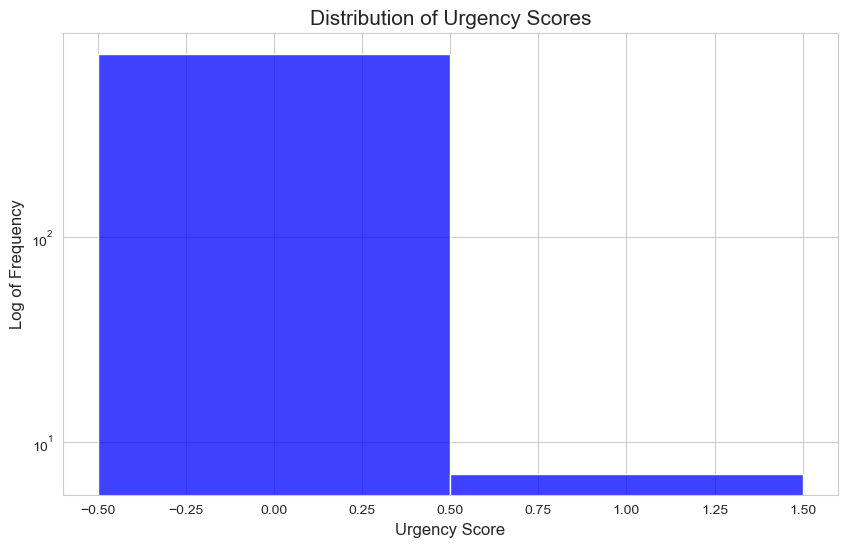

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram for urgency scores
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=initial_tweets_df, x='urgency_score', discrete=True, kde=False, color='blue', bins=[-0.5, 0.5, 1.5])

# Set log scale
plt.yscale('log')

# Adding title and labels
plt.title('Distribution of Urgency Scores', fontsize=15)
plt.xlabel('Urgency Score', fontsize=12)
plt.ylabel('Log of Frequency', fontsize=12)

# Display the plot
plt.show()

### Topic Modeling - Model Training